In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 417.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 8.0.0 which is incompatible.


In [2]:
import yfinance as yf
from datetime import date
from dateutil.relativedelta import relativedelta 
import datetime as dt

today = date.today()
one_years = date.today() - relativedelta(months=+36)
df = yf.download('BZ=F', start=one_years, end=dt.datetime.now(), progress=False)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-27 00:00:00-05:00,60.279999,60.490002,58.50,59.320000,59.320000,39367
2020-01-28 00:00:00-05:00,58.950001,60.110001,58.50,59.509998,59.509998,41537
2020-01-29 00:00:00-05:00,59.669998,60.610001,59.25,59.810001,59.810001,21453
2020-01-30 00:00:00-05:00,59.610001,59.610001,57.73,58.290001,58.290001,17435
2020-01-31 00:00:00-05:00,59.070000,59.529999,57.98,58.160000,58.160000,578


In [3]:
date.today()

datetime.date(2023, 1, 25)

In [4]:
del df['Open'], df['High'], df['Low'], df['Adj Close'], df['Volume']
df.head()

,Close
Date,
2020-01-27 00:00:00-05:00,59.320000
2020-01-28 00:00:00-05:00,59.509998
2020-01-29 00:00:00-05:00,59.810001
2020-01-30 00:00:00-05:00,58.290001
2020-01-31 00:00:00-05:00,58.160000


Text(0.5, 1.0, 'Crude Oil Price')

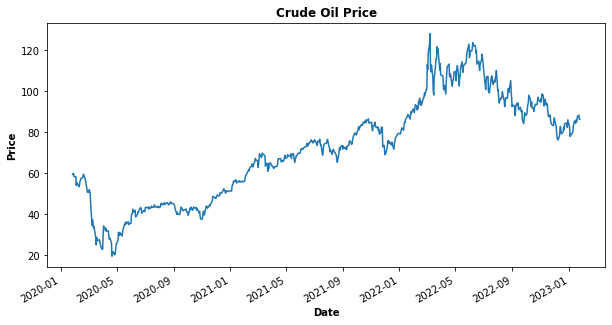

In [5]:
import matplotlib.pyplot as plt

df['Close'].plot(figsize=(10,5))
plt.ylabel('Price',fontweight='bold')
plt.xlabel('Date',fontweight='bold')
plt.title('Crude Oil Price',fontweight='bold')

In [6]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
print("Train : ",train_size)
print("Test : ",test_size)

Train :  680
Test :  76


In [7]:
train = df.iloc[:train_size]
train

,Close
Date,
2020-01-27 00:00:00-05:00,59.320000
2020-01-28 00:00:00-05:00,59.509998
2020-01-29 00:00:00-05:00,59.810001
2020-01-30 00:00:00-05:00,58.290001
2020-01-31 00:00:00-05:00,58.160000
...,...
2022-09-30 00:00:00-04:00,87.959999
2022-10-03 00:00:00-04:00,88.860001
2022-10-04 00:00:00-04:00,91.800003


In [8]:
test = df.iloc[train_size:]
test

,Close
Date,
2022-10-07 00:00:00-04:00,97.919998
2022-10-10 00:00:00-04:00,96.190002
2022-10-11 00:00:00-04:00,94.290001
2022-10-12 00:00:00-04:00,92.449997
2022-10-13 00:00:00-04:00,94.570000
...,...
2023-01-19 00:00:00-05:00,86.160004
2023-01-20 00:00:00-05:00,87.629997
2023-01-23 00:00:00-05:00,88.190002


In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [10]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 25
n_features = 1

time_series_generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)
time_series_val_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras import initializers
import tensorflow as tf

initializer = tf.keras.initializers.he_uniform(seed=0)

model = Sequential()
model.add(LSTM(25, activation='relu', input_shape=(length, n_features), kernel_initializer=initializer, bias_initializer=initializers.Constant(0.01)))
model.add(Dense(1,activation='linear', kernel_initializer=initializer, bias_initializer=initializers.Constant(0.01)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8)
model.compile(optimizer=opt, loss='mse')

2023-01-25 08:23:24.980372: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

Early_Stopping = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

model.fit_generator(time_series_generator, epochs=100, validation_data=time_series_val_generator, callbacks=[Early_Stopping])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-01-25 08:23:25.273168: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
655/655 [==============================] - 6s 7ms/step - loss: 0.0205 - val_loss: 0.0022
Epoch 2/100
655/655 [==============================] - 4s 7ms/step - loss: 0.0019 - val_loss: 6.8079e-04
Epoch 3/100
655/655 [==============================] - 4s 7ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 4/100
655/655 [==============================] - 4s 6ms/step - loss: 9.1761e-04 - val_loss: 3.5460e-04
Epoch 5/100
655/655 [==============================] - 5s 7ms/step - loss: 7.7709e-04 - val_loss: 6.4527e-04
Epoch 6/100
655/655 [==============================] - 4s 6ms/step - loss: 8.1171e-04 - val_loss: 0.0066
Epoch 7/100
655/655 [==============================] - 4s 7ms/step - loss: 9.5290e-04 - val_loss: 6.1340e-04
Epoch 8/100
655/655 [==============================] - 4s 7ms/step - loss: 7.3262e-04 - val_loss: 8.4737e-04
Epoch 9/100
655/655 [==============================] - 4s 7ms/step - loss: 7.6810e-04 - val_loss: 3.9232e-04
Epoch 10/100
655/655 [=====================

Text(0, 0.5, "Loss-'MSE'")

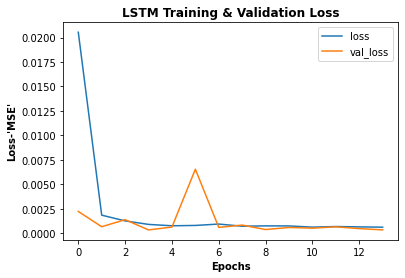

In [13]:
import pandas as pd

loss = pd.DataFrame(model.history.history)
loss.plot()
plt.title('LSTM Training & Validation Loss',fontweight='bold')
plt.xlabel('Epochs',fontweight='bold')
plt.ylabel("Loss-'MSE'",fontweight='bold')

In [14]:
import numpy as np

test_outputs = []
batch = scaled_test[:length].reshape((1, length, n_features))

for i in range(len(scaled_test)):
    test_out = model.predict(batch)[0]
    test_outputs.append(test_out) 
    batch = np.append(batch[:,1:,:],[[scaled_test[i]]],axis=1)

In [15]:
actual_test=scaled_test
actual_test=scaler.inverse_transform(actual_test)

In [16]:
test_predictions=scaler.inverse_transform(test_outputs)

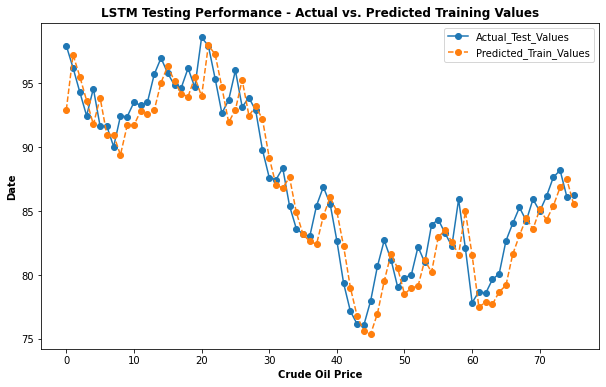

In [17]:
plt.figure(figsize=(10,6))
plt.plot(actual_test,marker='o',linestyle='-')

plt.plot(test_predictions,marker='o',linestyle='dashed')
plt.title('LSTM Testing Performance - Actual vs. Predicted Training Values',fontweight='bold')
plt.legend(('Actual_Test_Values','Predicted_Train_Values'))
plt.xlabel('Crude Oil Price',fontweight='bold')
plt.ylabel('Date',fontweight='bold');

In [18]:
test['LSTM Predictions'] = test_predictions
test

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Close,LSTM Predictions
Date,,
2022-10-07 00:00:00-04:00,97.919998,92.914021
2022-10-10 00:00:00-04:00,96.190002,97.213091
2022-10-11 00:00:00-04:00,94.290001,95.505261
2022-10-12 00:00:00-04:00,92.449997,93.634500
2022-10-13 00:00:00-04:00,94.570000,91.770002
...,...,...
2023-01-19 00:00:00-05:00,86.160004,84.307163
2023-01-20 00:00:00-05:00,87.629997,85.394510
2023-01-23 00:00:00-05:00,88.190002,86.844989


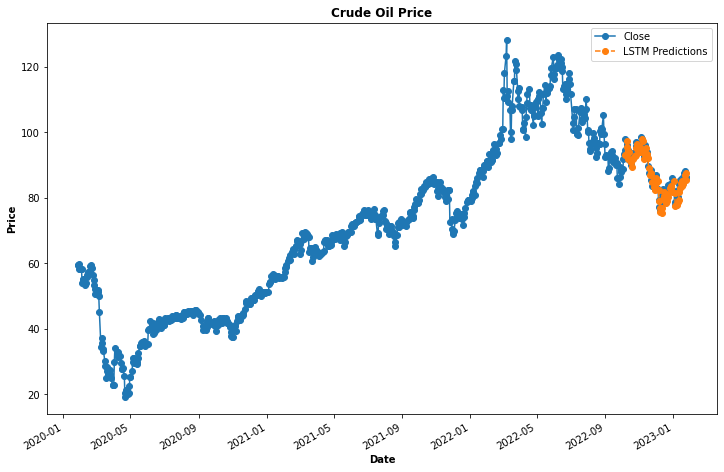

In [19]:
ax=df.plot(figsize=(12,8), marker='o',linestyle='-')

test['LSTM Predictions'].plot(ax=ax,legend=True, marker='o',linestyle='dashed')
plt.title('Crude Oil Price',fontweight='bold')
plt.ylabel('Price',fontweight='bold')
plt.xlabel('Date',fontweight='bold');

In [20]:
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(test['Close'],test['LSTM Predictions'])))

2.0592356487133885


In [21]:
outputs = []
batch = scaled_test[:length].reshape((1, length, n_features))

for i in range(7):
    test_out = model.predict(batch)[0]
    outputs.append(test_out) 
    batch = np.append(batch[:,1:,:],[[scaled_test[i]]],axis=1)

In [22]:
predictions=scaler.inverse_transform(outputs)

In [23]:
pred_index = pd.date_range(start=pd.to_datetime(date.today()),periods=7,freq='D')
df_predict = pd.DataFrame(predictions, index=pred_index, columns=['Prediction'])
df_predict

,Prediction
2023-01-25,92.914021
2023-01-26,97.213091
2023-01-27,95.505261
2023-01-28,93.634500
2023-01-29,91.770002
2023-01-30,93.845982
2023-01-31,90.954493


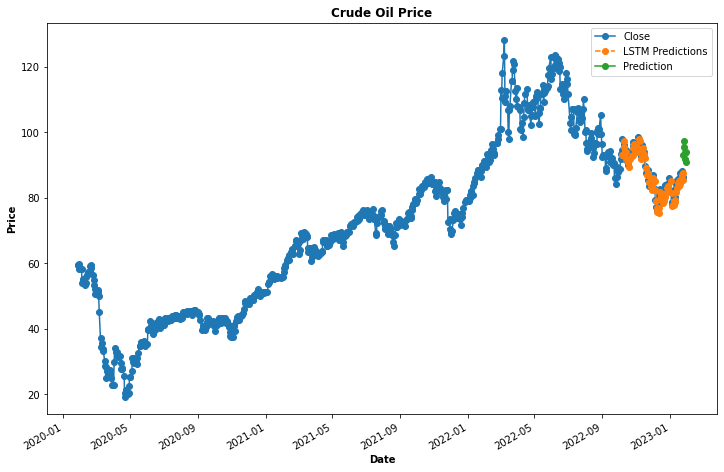

In [24]:
ax=df.plot(figsize=(12,8), marker='o',linestyle='-')

test['LSTM Predictions'].plot(ax=ax,legend=True, marker='o',linestyle='dashed')
df_predict['Prediction'].plot(ax=ax,legend=True, marker='o')
plt.title('Crude Oil Price',fontweight='bold')
plt.ylabel('Price',fontweight='bold')
plt.xlabel('Date',fontweight='bold');